In [36]:
from datetime import datetime
import pandas as pd
from geopy import distance
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import normalize

import statsmodels.api as sm


from sklearn.model_selection import cross_validate


import pymongo
from pymongo import MongoClient

import matplotlib.pyplot as plt

plt.style.use("ggplot")

%matplotlib inline

In [22]:
client = MongoClient('localhost', 27017)

db = client['avl_pipeline_test']
in_coll = db['edges_normed_constrained']

In [23]:
cursor = in_coll.find()

In [24]:
df =  pd.DataFrame(list(cursor))

In [25]:
df.head()

,_id,edge_id,edge_trip_id,first_prior,normed_edge,second_prior,sequence,temporal
0,5ae8e1363ad39e8cbfc4bc43,7253717_2016-10-28_HKH3O_1,7253717_2016-10-28_HKH3O,0.000000,0.030549,0.000000,1,480249
1,5ae8e1363ad39e8cbfc4bc44,7253717_2016-10-28_HKH3O_2,7253717_2016-10-28_HKH3O,0.030549,-0.578122,0.000000,2,480249
2,5ae8e1363ad39e8cbfc4bc45,7253717_2016-10-28_HKH3O_3,7253717_2016-10-28_HKH3O,-0.578122,-0.588278,0.030549,3,480249
3,5ae8e1363ad39e8cbfc4bc46,7253717_2016-10-28_HKH3O_4,7253717_2016-10-28_HKH3O,-0.588278,0.402000,-0.578122,4,480249
4,5ae8e1363ad39e8cbfc4bc47,7253717_2016-10-28_HKH3O_5,7253717_2016-10-28_HKH3O,0.402000,-0.099564,-0.588278,5,480249


In [26]:
df.shape

(43411, 8)

In [27]:
y = df['normed_edge'].values.reshape(-1,1)
X = df[['first_prior', 'second_prior', 'temporal']].values

In [28]:
y.shape

(43411, 1)

In [29]:
X.shape

(43411, 3)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [31]:
# With RF
regr = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=0, max_features=2)
regr.fit(X_train, y_train.flatten())
regr.score(X_test, y_test.flatten())

0.04633473819898537

In [32]:
regr.predict([[-0.588278, -0.578122, 480249]])

array([-0.47745275])

In [46]:
regr_cv = RandomForestRegressor(max_depth=2, random_state=0)
crossed = cross_validate(regr, X, y.flatten(), cv=20)
crossed['test_score'].mean()

0.03891432555148495

In [41]:
sub_sect_df = df[['first_prior', 'second_prior', 'temporal']]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


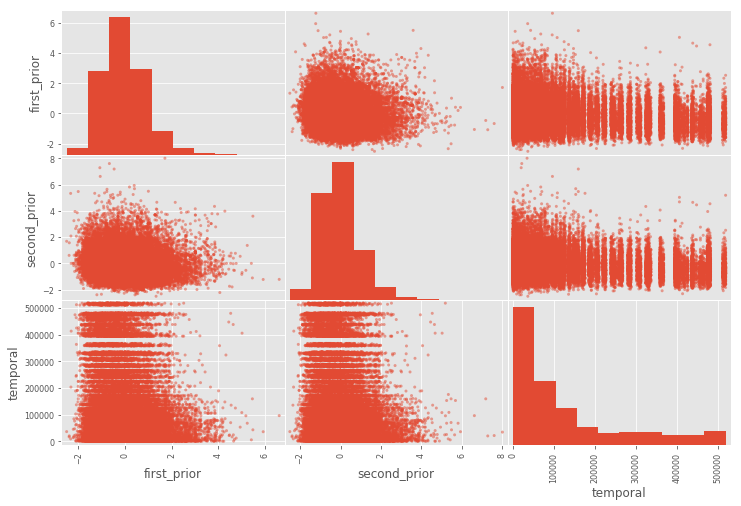

In [43]:
pd.scatter_matrix(sub_sect_df, figsize=(12, 8));

In [44]:
norm_edges = df['normed_edge'].values
sequences = df['temporal'].values

Text(0,0.5,'Normalized edge duration')

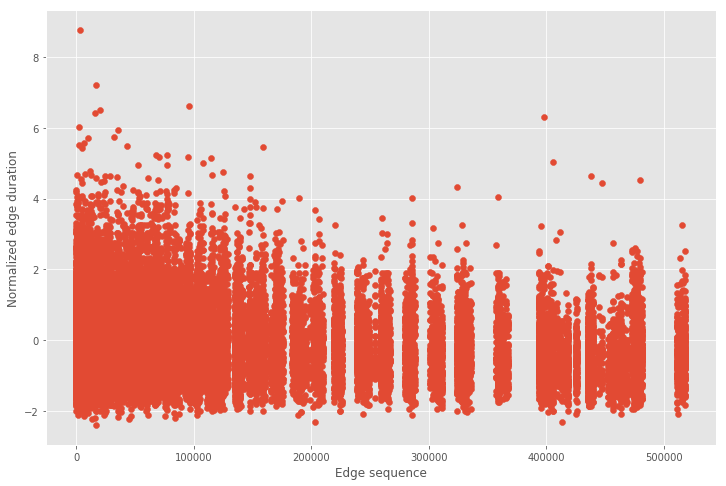

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(sequences, norm_edges)
ax.set_xlabel("Edge sequence")
ax.set_ylabel("Normalized edge duration")

In [10]:
# fit with statsmodels
model1 = sm.OLS(y_train,X_train)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     352.1
Date:                Tue, 01 May 2018   Prob (F-statistic):          4.87e-225
Time:                        14:52:16   Log-Likelihood:                -44282.
No. Observations:               32558   AIC:                         8.857e+04
Df Residuals:                   32555   BIC:                         8.860e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0650      0.006    -11.421      0.000      -0.076      -0.054
x2             0.0630      0.006     11.185      0.000       0.052       0.074
x3         -7.926e-07   2.86e-08    -27.708      0.000   -8.49e-07   -7.37e-07
==============================================================================
Omnibus:                     4953.420   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9846.350
Skew:                           0.940   Prob(JB):                         0.00
Kurtosis:                       4.931   Cond. No.                     2.08e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
# fit with sklearn OLS
ols = LinearRegression()
ols.fit(X_train, y_train)
ols.score(X_test, y_test)

0.03936476585980542

In [12]:
# With RF
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train.flatten())
regr.score(X_test, y_test.flatten())

0.032999163098690554

What about just weekend data?

In [13]:
wk_df = df[df['weekend'] == 1]
y = wk_df['normed_edge'].values.reshape(-1,1)
X = wk_df[['first_prior', 'second_prior', 'midday', 'rush_hour']].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [14]:
# fit with sklearn OLS
ols = LinearRegression()
ols.fit(X_train, y_train)
ols.score(X_test, y_test)

0.023276449174933878

In [15]:
# With RF
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train.flatten())
regr.score(X_test, y_test.flatten())

0.016887043289314785

# What about non-normalized?

In [30]:
stand_coll = db['edges_standardized']
std_cursor = stand_coll.find()
std_df =  pd.DataFrame(list(std_cursor))

In [33]:
y = std_df['standard_edge'].values.reshape(-1,1)
X = std_df[['first_prior', 'second_prior', 'midday', 'rush_hour', 'weekend']].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [34]:
# fit with sklearn OLS
ols = LinearRegression()
ols.fit(X_train, y_train)
ols.score(X_test, y_test)

0.01391835062696567

In [35]:
# With RF
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train.flatten())
regr.score(X_test, y_test.flatten())

0.02045907040064232